# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score 
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Заменим пропуски в сроке обслуживания на -1

In [5]:
df['Tenure'] = df['Tenure'].fillna(-1)

In [6]:
df['Tenure'].value_counts()

 1.0     952
 2.0     950
 8.0     933
 3.0     928
 5.0     927
 7.0     925
-1.0     909
 4.0     885
 9.0     882
 6.0     881
 10.0    446
 0.0     382
Name: Tenure, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [8]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

У нас 10000 наблюдений и 14 признаков, целевой признак Exited — факт ухода клиента 1
Мы видим дисбаланс классов, ушедших клиентов в 4 раза меньше оставшихся

Избавимся от признаков с которыми не будем работать:
RowNumber - дублирует индекс и не влияет на целевой признак, также уберем: CustomerId и Surname:

In [9]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [10]:
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


Создадим дамми-признаки

In [11]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.columns = df_ohe.columns.str.lower()
df_ohe.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


Выделим целевой признак

In [12]:
y = df_ohe['exited']
x = df_ohe.drop('exited', axis=1)

Разделим на 3 выборки

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=0.6, 
                                                    random_state=42,
                                                    stratify=y).copy()

In [14]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, 
                                                    train_size=0.5, 
                                                    random_state=42,
                                                    stratify=y_test).copy()

In [15]:
print(y_train.value_counts(normalize=True)) 
print(y_valid.value_counts(normalize=True)) 
print(y_test.value_counts(normalize=True)) 

0    0.796333
1    0.203667
Name: exited, dtype: float64
0    0.796
1    0.204
Name: exited, dtype: float64
0    0.7965
1    0.2035
Name: exited, dtype: float64


In [16]:
print(len(x_train))
print(len(x_test))
print(len(x_valid))
print(len(x_train)+len(x_valid)+len(x_test))

6000
2000
2000
10000


Разбиение прошло успешно

Сделаем масштабирование, приведём все числовые фичи к одной шкале.

In [17]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

In [18]:
scaler = StandardScaler()

In [19]:
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
x_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_germany,geography_spain,gender_male
6851,-1.283897,0.008566,1.396319,0.330105,0.783996,1,0,-0.084061,1,0,0
7026,0.271537,-1.139895,-1.679499,-1.220584,0.783996,0,1,0.264021,0,0,0
5705,-0.236571,0.104271,0.165992,1.692794,0.783996,1,1,0.515344,1,0,1
9058,-1.874962,0.869911,-1.679499,1.032566,-0.919109,1,1,0.303842,0,1,0
9415,1.215167,0.391386,-0.756754,0.851257,0.783996,0,0,-1.400817,1,0,0


У нас получилось стандартизировать числовые переменные.

## Исследование задачи

У нас биноминальный целевой признак, используем алгоритмы классификации.
Начнем с классификатора дерева решений:

### Классификатор дерева решений

In [21]:
%%time
best_model = None
best_result = 0
for depth in range(2, 15):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth) 
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid) 
    result = f1_score(y_valid, y_pred)
    if result > best_result:
        best_model = model
        best_result = result
print(best_model)
print(best_result)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
0.5927007299270073
CPU times: user 241 ms, sys: 9.23 ms, total: 251 ms
Wall time: 268 ms


best_model

best_result

Наилучший результат с F1-мерой  0.59 дает модель дерева решений с максимальной глубиной глубиной 8

### Случайный лес

In [22]:
%%time
best_model = None
best_result = 0
for est in range(10, 100, 10):
    for depth in range (1, 30):
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth) 
        model.fit(x_train,y_train)
        y_pred = model.predict(x_valid) 
        result = f1_score(y_valid, y_pred) 
        if result > best_result:
            best_model = model
            best_result = result
print(best_model)
print(best_result)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.6242603550295858
CPU times: user 1min 9s, sys: 286 ms, total: 1min 10s
Wall time: 1min 10s


In [23]:
%%time
best_model = None
best_result = 0
for est in range(50, 70):
    for depth in range (10, 20):
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth) 
        model.fit(x_train,y_train)
        y_pred = model.predict(x_valid) 
        result = f1_score(y_valid, y_pred) 
        if result > best_result:
            best_model = model
            best_result = result
print(best_model)
print(best_result)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.6242603550295858
CPU times: user 1min 11s, sys: 236 ms, total: 1min 11s
Wall time: 1min 11s


Наилучший результат с F1-мерой 0.62 дает модель  случайного  леса с 60 деревьями и максимальной глубиной 16

### Логистическая регрессия

In [24]:
model = LogisticRegression(random_state=42, solver='liblinear') 
model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
y_pred = model.predict(x_valid) 
result = f1_score(y_valid, y_pred) ,
result

(0.32792792792792796,)

In [26]:
y_proba = model.predict_proba(x_valid)
auc_roc = roc_auc_score(y_valid, y_proba[:, 1])
auc_roc

0.7908091314415214

Очень низкий показатель F1-меры 0.33 дает модель логистической регрессии, AUC ROC  0.79.

Необходимо увеличить показатели точности и полносты:

## Борьба с дисбалансом

Для улучшения нашей модели избавимся от дисбаланса в числовых переменных:

numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

scaler = StandardScaler()

scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])


Теперь нам необходимо избавиться от дисбаланса классов, сделаем размножив редкий класс, наблюдения с ушедшими клиентами

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [28]:
x_upsampled, y_upsampled = upsample(x_train, y_train, 4)

In [29]:
print(len(x_train))
print(len(x_upsampled))
print(len(y_train))
print(len(y_upsampled))

6000
9666
6000
9666


У нас получилось избавиться от дисбаланса классов и в числовых переменных, теперь обучим нашу эффективную модель на обработанных данных:

In [30]:
%%time
best_model = None
best_result = 0
for est in range(10, 100, 10):
    for depth in range (1, 30):
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth) 
        model.fit(x_upsampled,y_upsampled)
        y_pred = model.predict(x_valid) 
        result = f1_score(y_valid, y_pred) 
        if result > best_result:
            best_model = model
            best_result = result
print(best_model)
print(best_result)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.6332288401253918
CPU times: user 1min 38s, sys: 344 ms, total: 1min 39s
Wall time: 1min 39s


In [31]:
%%time
best_model = None
best_result = 0
for est in range(45, 75):
    for depth in range (5, 20):
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth) 
        model.fit(x_upsampled,y_upsampled)
        y_pred = model.predict(x_valid) 
        result = f1_score(y_valid, y_pred) 
        if result > best_result:
            best_model = model
            best_result = result
print(best_model)
print(best_result)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=65,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.6358866736621196
CPU times: user 3min 31s, sys: 396 ms, total: 3min 31s
Wall time: 3min 31s


На валидационной выборке получили улучшение F1-меры до 0.6359 при 65 деревьях и максимальной глубине 9

Испытаем ещё 1 метод борьбы с дисбалансом:

In [32]:
%%time
best_model = None
best_result = 0
for est in range(10, 100, 10):
    for depth in range (1, 30):
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth, class_weight='balanced') 
        model.fit(x_train,y_train)
        y_pred = model.predict(x_valid) 
        result = f1_score(y_valid, y_pred) 
        if result > best_result:
            best_model = model
            best_result = result
print(best_model)
print(best_result)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=70, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
0.6334745762711864
CPU times: user 1min 12s, sys: 160 ms, total: 1min 12s
Wall time: 1min 12s


In [33]:
%%time
best_model = None
best_result = 0
for est in range(55, 80):
    for depth in range (5, 20):
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth, class_weight='balanced') 
        model.fit(x_train,y_train)
        y_pred = model.predict(x_valid) 
        result = f1_score(y_valid, y_pred) 
        if result > best_result:
            best_model = model
            best_result = result
print(best_model)
print(best_result)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=56, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)
0.635593220338983
CPU times: user 2min 20s, sys: 352 ms, total: 2min 20s
Wall time: 2min 20s


На валидационной выборке получили улучшение F1-меры до 0.6356 при 56 деревьях и максимальной глубине 8

Немного лучший результат дал апсэмплинг

## Тестирование модели

Проверим нашу модель на тестовой выборке:

In [35]:
model = RandomForestClassifier(random_state=42, n_estimators=65, max_depth=9)
model.fit(x_upsampled,y_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=65,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [36]:
y_pred = model.predict(x_test) 

In [37]:
result = f1_score(y_test, y_pred)
result

0.6221743810548979

F1-мера при проверке модели на тестовой выборке 0,62, выше нашего минимума в 0,59. Говорит о балансе точности и полноты нашей модели, её можно использовать.

In [38]:
y_proba = model.predict_proba(x_test)

In [39]:
auc_roc = roc_auc_score(y_test, y_proba[:, 1])
auc_roc

0.8605539283505385

Text(0.5, 1.0, 'ROC-кривая')

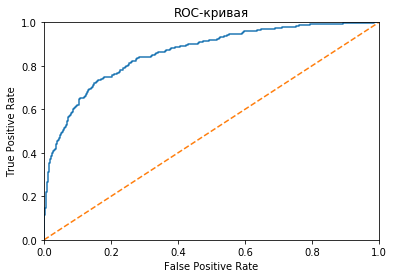

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1]) 

plt.figure()
plt.plot(fpr, tpr)# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

auc_roc = 0.86 показывает нам также, что модель хорошо справляется со своей задачей не упустить клиентов с высокой вероятностью уйти, при этом не сделав много лишних действйи в отношении других клиентов

Построим также матрицу ошибок:

In [41]:
print(confusion_matrix(y_test, y_pred))

[[1360  233]
 [ 118  289]]


Для 289 клиентов модель верно предсказала уход из банка, при этом упустила 118 ушедших клиентов и дала ложное предсказание ухода для 233.

## Вывод


В ходе работы мы выгрузили и изучили данные:  
На входе у нас было 10000 наблюдений и 14 признаков, целевой признак Exited — факт ухода клиента 1  
Мы отметили дисбаланс классов, ушедших клиентов в 4 раза меньше оставшихся  

Далее мы для правильной  работы алгоритма:  
 - избавились от лишних признаков  
 - создали дамми-признаки  
 - выделили целевой признак  
 - разделили на 3 выборки
 
Так как у нас биноминальный целевой признак, использовали алгоритмы классификации:

- классификатора дерева решений дал наилучший результат с F1-мерой 0.59 дает, с максимальной глубиной глубиной 8
- модель случайного леса дала наилучший результат с F1-мерой 0.62,  с 60 деревьями и максимальной глубиной 16
- модель логистической регрессии дала показатель F1-меры 0.33, AUC ROC 0.79 не сильно отличается от случайно модели

Для улучшения показателей точности и полноты нашей модели мы избавились от дисбаланса классов, обучили новую модель на измененных данных

F1-мера при проверке модели на тестовой выборке 0,62, выше нашего минимума в 0,59. Говорит о балансе точности и полноты нашей модели, её можно использовать.
auc_roc = 0.86 показывает нам также, что модель хорошо справляется со своей задачей не упустить клиентов с высокой вероятностью уйти, при этом не сделав много лишних действйи в отношении других клиентов